In [1]:
from segment_anything import sam_model_registry,SamAutomaticMaskGenerator
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
sam = sam_model_registry["vit_h"](checkpoint="model/h.pth")
device='cuda'
sam.to(device='cuda')


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [26]:
def getpoint(mask):
    points=[]
    labels=[]
    for label in range(1,14):
        organ_mask=(mask==label)
        if torch.any(organ_mask):
            seg=torch.where(organ_mask)
            xmin=torch.min(seg[1]).item()
            xmax=torch.max(seg[1]).item()
            ymin=torch.min(seg[0]).item()
            ymax=torch.max(seg[0]).item()

            x=(xmin+xmax)//2
            y=(ymin+ymax)//2
            if mask[y,x]==label:
                points.append((x,y))
                labels.append(label)
            else:
                while True:
                    x=np.random.randint(xmin,xmax+1)
                    y=np.random.randint(ymin,ymax+1)
                    if mask[y,x]==label:
                        points.append((x,y))
                        labels.append(label)
                        break
    return points,labels


In [12]:
from dataset import BTCV2DSliceDataset
data_set=BTCV2DSliceDataset("RawData/Training","dataset_0.json","validation")

(762, 512, 512)
(762, 512, 512)


In [33]:
from torch.utils.data import DataLoader
import tqdm
from segment_anything import SamPredictor

predictor=SamPredictor(sam)
data_loader=DataLoader(data_set,batch_size=1,shuffle=False)
total_intersection = dict()  # organ_id -> total intersect pixels
total_mask_pixels = dict()   # organ_id -> total mask pixels
total_dice=dict()
total_num=dict()
for i in range(1,14):
    total_intersection[i]=0
    total_mask_pixels[i]=0
    total_dice[i]=0
    total_num[i]=0
# Dice = 2 * intersect / total mask pixels 
# mDice = Average Dice over all categories
input_label=np.array([1])
k=0
for i in tqdm.tqdm(data_loader):
    k+=1
    if k%50==0 :
        """"
        dice = dict([(organ_id , 2 * total_intersection[organ_id] / max(1,total_mask_pixels[organ_id])) for organ_id in total_intersection])
        mDice = np.mean(list(dice.values()))
        print(k)
        print(dice)
        print(mDice)
        """
        dice = dict([(organ_id , total_dice[organ_id] / max(1,total_num[organ_id])) for organ_id in total_intersection])
        mDice = np.mean(list(dice.values()))
        print(k)
        print(dice)
        print(mDice)
    points,labels=getpoint(i['label'][0])
    if len(points)==0:
        continue
    predictor.set_image(i['image'][0,:,:,:].numpy())
    for j in range (len(points)):
        masks, scores, logits = predictor.predict(
        point_coords=np.expand_dims(np.array(points[j]),0),
        point_labels=input_label,
        multimask_output=False,
        )
        gt_mask = (i['label'][0,:,:] == labels[j]).cpu()

        pred_mask = torch.Tensor(masks)

        intersection = torch.sum(torch.logical_and(gt_mask ,pred_mask)).item()
        total_pixels = torch.sum(gt_mask).item() + torch.sum(pred_mask).item()
        """
        print(i['label'][0][points[j][0],points[j][1]])
        plt.imshow(i['image'][0])
        plt.show()
        plt.imshow(gt_mask)
        plt.show()
        plt.imshow(pred_mask[0])
        plt.show()
        print(pred_mask[0][points[j][0],points[j][1]])
        print(intersection)
        print(total_pixels)
        """


        total_dice[labels[j]]+=2*intersection/total_pixels
        total_num[labels[j]]+=1
        total_intersection[labels[j]] += intersection
        total_mask_pixels[labels[j]] += total_pixels 

    predictor.reset_image()



  6%|▌         | 47/762 [00:01<00:25, 27.72it/s]

50
{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.9233716475095786, 9: 0.5207945509732202, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0}
0.1110897075755999


 19%|█▉        | 147/762 [01:01<00:33, 18.38it/s]

100
{1: 0.1376375074954036, 2: 0.7466327574891313, 3: 0.7612615633582379, 4: 0.0, 5: 0.20619620961598323, 6: 0.21371851903645442, 7: 0.15105215455504994, 8: 0.9140424426330452, 9: 0.6649841798653672, 10: 0.09098101480312017, 11: 0.08614306075230503, 12: 0.0033275444735947055, 13: 0.003156193717889059}
0.3060871652150447
150
{1: 0.1376375074954036, 2: 0.7466327574891313, 3: 0.7612615633582379, 4: 0.0, 5: 0.20619620961598323, 6: 0.21371851903645442, 7: 0.15105215455504994, 8: 0.9140424426330452, 9: 0.6649841798653672, 10: 0.09098101480312017, 11: 0.08614306075230503, 12: 0.0033275444735947055, 13: 0.003156193717889059}
0.3060871652150447


 25%|██▌       | 191/762 [01:15<02:22,  4.02it/s]

200
{1: 0.1376375074954036, 2: 0.7228326091433913, 3: 0.7437536351829229, 4: 0.0, 5: 0.20619620961598323, 6: 0.19496105949073714, 7: 0.15105215455504994, 8: 0.9180275586376715, 9: 0.722447896669967, 10: 0.09098101480312017, 11: 0.08614306075230503, 12: 0.0033275444735947055, 13: 0.003156193717889059}
0.30619357265677194


 33%|███▎      | 249/762 [02:30<11:03,  1.29s/it]

250
{1: 0.17236666382965726, 2: 0.8353828783281859, 3: 0.8148163775409835, 4: 0.012487735015459033, 5: 0.1611339811092298, 6: 0.30164520422988034, 7: 0.13740690777557646, 8: 0.8697389984942003, 9: 0.6061938242913023, 10: 0.10537217983039576, 11: 0.0642503044955569, 12: 0.00832026661626977, 13: 0.05576825954525112}
0.31883719854630377


 36%|███▋      | 278/762 [03:06<10:00,  1.24s/it]

300
{1: 0.15659717977191986, 2: 0.8353828783281859, 3: 0.8148163775409835, 4: 0.012487735015459033, 5: 0.23746909681399764, 6: 0.3429760883887923, 7: 0.13119211719994242, 8: 0.8580545954980084, 9: 0.5791062407819032, 10: 0.10537217983039576, 11: 0.0642503044955569, 12: 0.00832026661626977, 13: 0.05576825954525112}
0.32321487075589744


 46%|████▌     | 349/762 [03:31<08:44,  1.27s/it]

350
{1: 0.1702525407682071, 2: 0.8246034733918478, 3: 0.8048982873868787, 4: 0.01874658935322138, 5: 0.23746909681399764, 6: 0.30922907497377866, 7: 0.16444403709892563, 8: 0.8655694904103197, 9: 0.5744422761713726, 10: 0.10170129653005501, 11: 0.07726384016854726, 12: 0.00832026661626977, 13: 0.05576825954525112}
0.3240545022483595


 49%|████▉     | 377/762 [04:06<07:43,  1.20s/it]

400
{1: 0.16234945392531325, 2: 0.8094970773959628, 3: 0.792296393189833, 4: 0.018300398236927612, 5: 0.20642970511670258, 6: 0.3099717466443868, 7: 0.15793453958826695, 8: 0.8703965169891188, 9: 0.5329930189988109, 10: 0.09268150170111038, 11: 0.07423359556312091, 12: 0.007066554574805339, 13: 0.04490976993791741}
0.313773867066329


 59%|█████▉    | 449/762 [04:46<07:14,  1.39s/it]

450
{1: 0.16590277642730725, 2: 0.8225776667603454, 3: 0.8052075131583507, 4: 0.01611556403424906, 5: 0.20642970511670258, 6: 0.3469973007808897, 7: 0.21600219143742047, 8: 0.8656700041299628, 9: 0.5660170737397769, 10: 0.09005953599711754, 11: 0.11544970629266328, 12: 0.01629510567364204, 13: 0.039376929834140574}
0.3286231594909668


 68%|██████▊   | 517/762 [05:22<00:17, 14.01it/s]

500
{1: 0.14629376265233351, 2: 0.8157346079155792, 3: 0.7918442975900867, 4: 0.015086035034413381, 5: 0.1923434366623618, 6: 0.33533134791634833, 7: 0.25592612557356065, 8: 0.8521339285831837, 9: 0.5121758443067082, 10: 0.07439044483613433, 11: 0.10767636434013374, 12: 0.017395058113978876, 13: 0.03309460235130429}
0.31918660429816365


 72%|███████▏  | 546/762 [05:52<02:34,  1.40it/s]

550
{1: 0.19222078241253207, 2: 0.8258925172712447, 3: 0.8021843737817219, 4: 0.05504347247535128, 5: 0.1923434366623618, 6: 0.3747776961814685, 7: 0.26754087051957276, 8: 0.8576775597018502, 9: 0.5489308682550245, 10: 0.1653665961156584, 11: 0.17987934689318916, 12: 0.02014127907265522, 13: 0.03023028390304637}
0.3470945448650521


 81%|████████  | 619/762 [06:20<00:09, 14.39it/s]

600
{1: 0.24210327628047634, 2: 0.8258925172712447, 3: 0.7960926998915174, 4: 0.05504347247535128, 5: 0.19200065262387642, 6: 0.3795821957659689, 7: 0.30071077853490347, 8: 0.8626388444221739, 9: 0.5261000276874425, 10: 0.17404995476510005, 11: 0.17715269338409967, 12: 0.0187922490873654, 13: 0.028258064154171664}
0.35218595587259166


 85%|████████▍ | 647/762 [06:35<00:38,  2.97it/s]

650
{1: 0.24210327628047634, 2: 0.823943311288165, 3: 0.803843748436519, 4: 0.05504347247535128, 5: 0.19200065262387642, 6: 0.37765171172228035, 7: 0.3020088416123893, 8: 0.8638484096744803, 9: 0.5268297338799662, 10: 0.17404995476510005, 11: 0.17715269338409967, 12: 0.0187922490873654, 13: 0.028258064154171664}
0.3527327784141724


 92%|█████████▏| 699/762 [07:43<01:19,  1.26s/it]

700
{1: 0.2817309909611881, 2: 0.8316805077975086, 3: 0.8176052339417088, 4: 0.10760312584326497, 5: 0.20908257693479315, 6: 0.3779873235812613, 7: 0.37340809773730804, 8: 0.8656380018458505, 9: 0.5093721245831281, 10: 0.21865850389374353, 11: 0.15471959860330484, 12: 0.01667644908596116, 13: 0.023012018733123644}
0.3682441964263188


100%|██████████| 762/762 [08:43<00:00,  1.45it/s]

750
{1: 0.2817309909611881, 2: 0.8316805077975086, 3: 0.8176052339417088, 4: 0.10760312584326497, 5: 0.14948735957980533, 6: 0.3779873235812613, 7: 0.37340809773730804, 8: 0.8374618219480745, 9: 0.5080227030511462, 10: 0.21865850389374353, 11: 0.15471959860330484, 12: 0.01667644908596116, 13: 0.023012018733123644}
0.36138874882749217


In [30]:
dice = dict([(organ_id , total_dice[organ_id] / max(1,total_num[organ_id])) for organ_id in total_intersection])

mDice = np.mean(list(dice.values()))
        
print(dice)
print(mDice)

{1: 0.10338873792916958, 2: 0.3767626144132309, 3: 0.3697372531324841, 4: 0.01391401951891704, 5: 0.015278695929366762, 6: 0.2850908720691502, 7: 0.16737706370698044, 8: 0.27040608932468146, 9: 0.037544824030323366, 10: 0.021111905473583013, 11: 0.03585551680505556, 12: 0.002903463115422953, 13: 0.0029902776180008644}
0.13095087177433587


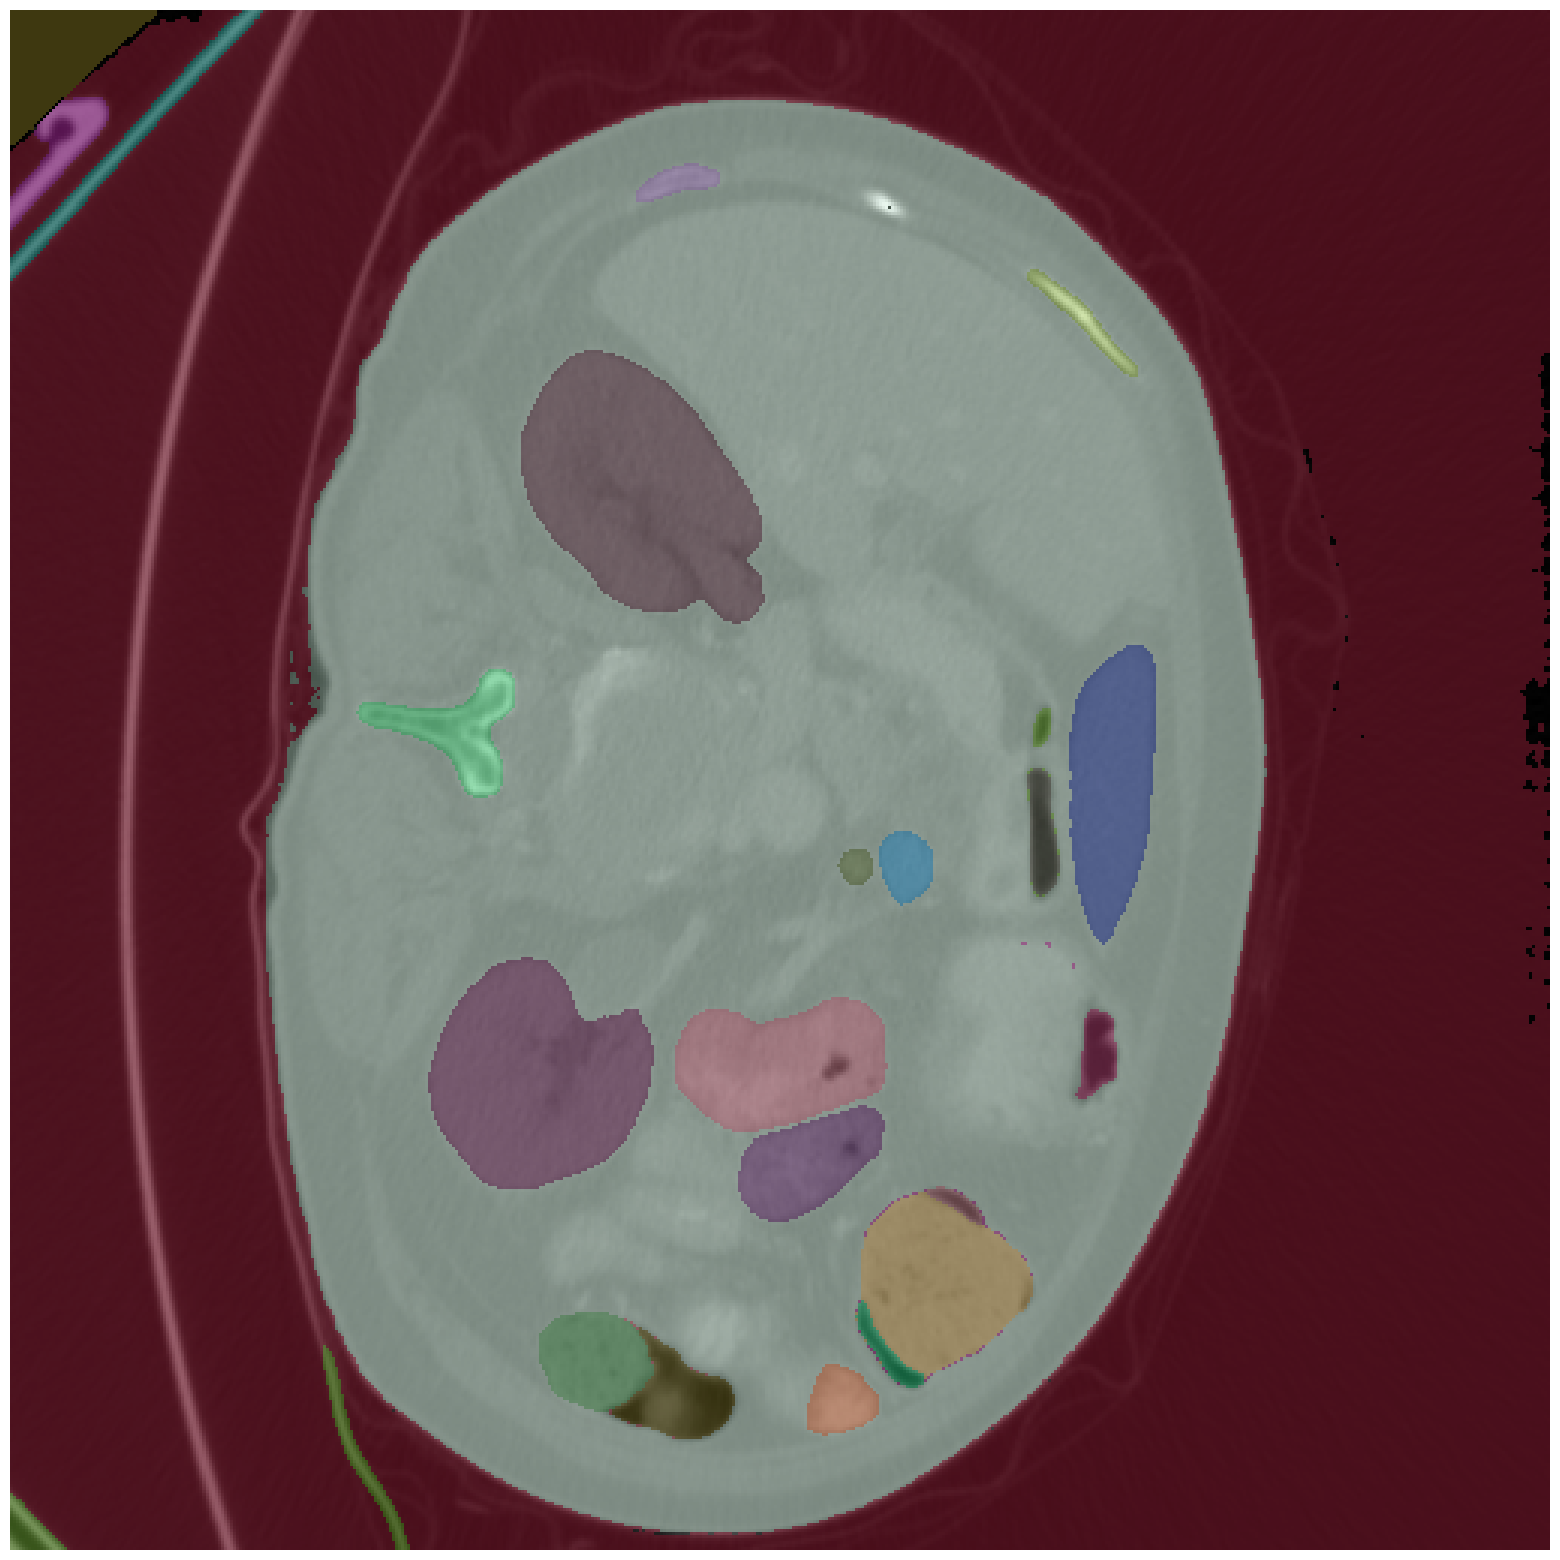

[{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 127343, 'bbox': [85, 30, 332, 475], 'predicted_iou': 1.0251885652542114, 'point_coords': [[328.0, 360.0]], 'stability_score': 0.9743969440460205, 'crop_box': [0, 0, 512, 512]}, {'segmentation': array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 1137, 'bbox': [0, 0, 48, 44], 'predicted_iou': 0.9913353323936462, 'poin

In [ ]:
for i in data:
    masks=mask_generator.generate(data[100]['image'])
    plt.figure(figsize=(20,20))
    plt.imshow(data[100]['image'])
    show_anns(masks)
    plt.axis('off')
    plt.show() 
    print(masks)
    break

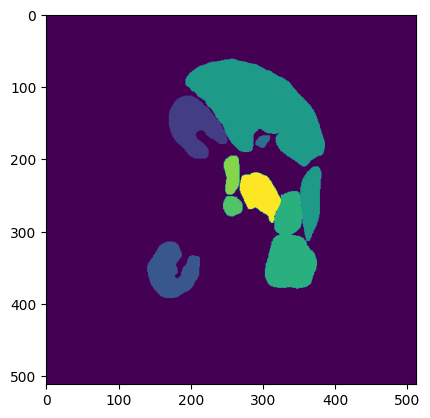

In [ ]:
plt.imshow(data[100]['label'])